# Lecture 13

by Martin Hronec

May 15-16

### Table of contents

1. [Decorators](#decorators)
2. [Dask](#Dask)

## Decorators
* [nice (very long) tutorial](https://realpython.com/primer-on-python-decorators/) 


**Functions (review)**
* to understand *decorators*, quick review of functions in Python
* functions are *first-class objects* (can be passed around and used as arguments, just like any other object)

In [2]:
def x(a,b):
    print(f"param 1: {a}, param 2: {b}")
    
# y expects function
def y(z,t):
    z(*t)

In [3]:
y(x,("hello","world"))

param 1: hello, param 2: world


In [4]:
# what if we return the function 
def y_(z,t):
    return(z)

In [6]:
# y_(x,("hello","manuel"))

* possibility to define *inner functions*
    * the inner functions are not defined until the parent function is called

In [12]:
def parent():
    print("Silence of the parent() function")

    def first_child():
        print("Noise from the first_child() function")

    def second_child():
        print("Signal from the second_child() function")

    second_child()
    first_child()

In [13]:
parent()

Silence of the parent() function
Signal from the second_child() function
Noise from the first_child() function


* they only exist inside the parent() function as local variables
    * try to call `second_child()` 

In [14]:
second_child()

NameError: name 'second_child' is not defined

* we can also return the inner function (reference to it, since we are not running it)

In [19]:
def parent():
    print("Silence of the parent() function")

    def first_child():
        print("Noise from the first_child() function")

    def second_child():
        print("Signal from the second_child() function")

    return(second_child)

In [20]:
papa_func = parent()
papa_func

Silence of the parent() function


<function __main__.parent.<locals>.second_child()>

### Simple decorators

In [25]:
def my_decorator(func):
    def wrapper():
        print("Action-holder BEFORE the function is called.")
        func()
        print("Action-holder ALFTER the function is called.")
    return wrapper

def say_smthng():
    print("Not enough coffee.")

In [26]:
# this is where the decoration happens
beg_for_coffee = my_decorator(say_smthng)

* `say_smthng` points to the `wrapper()` (inner function )
    * we return `wrapper` as a function, when calling my_decorator
* decorators wrap a function, modifying its behavior

In [33]:
from datetime import datetime

def not_after_six(func):
    def wrapper():
        if 5 <= datetime.now().hour < 19:
            func()
        else:
            pass  # Don't drink coffee af night (if you do, do it with bacon only)
    return wrapper

def say_smthng():
    print("Not enough coffee.")

say_smthng = not_after_six(say_smthng)

In [34]:
say_smthng() 

Not enough coffee.


* decoration process above is a little ugly
    * use `@` - *pie syntax*

In [35]:
def my_decorator(func):
    def wrapper():
        print("Action-holder BEFORE the function is called.")
        func()
        print("Action-holder ALFTER the function is called.")
    return wrapper

@my_decorator
def say_smthng():
    print("Not enough coffee.")

* `@my_decorator` is just an easier way of saying `say_whee = my_decorator(say_whee)`
    * this is how we apply a decorator to a function
* decorators are just a regular Python functions 

In [36]:
# another decorator example
def do_twice(func):
    def wrapper_do_twice():
        func()
        func()
    return wrapper_do_twice

In [39]:
@do_twice
def say_smthng():
    print("Not enough coffee.")

In [41]:
say_smthng()

Not enough coffee.
Not enough coffee.


**Decorating functions with arguments**

* what if the inner function does not take any argument, but we pass something to it?

In [43]:
def do_twice(func):
    def wrapper_do_twice():
        func()
        func()
    return wrapper_do_twice

@do_twice
def greet(name):
    print(f"Hello {name}")

In [44]:
greet("World")

TypeError: wrapper_do_twice() takes 0 positional arguments but 1 was given

* use `*args` (Non Keyword Arguments) and `**kwargs` (Keyword Arguments) in the inner wrapper function
    * it will accept an arbitrary number of positional and keyword arguments
    

In [51]:
def do_twice(func):
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        func(*args, **kwargs)
    return wrapper_do_twice

@do_twice
def greet(name):
    print(f"Hello {name}")

* `wrapper_do_twice()` inner function now accepts any number of arguments and passes them on to the function it decorates.

In [52]:
greet("World")

Hello World
Hello World


**return value of decorated functions**
* what happens to the return value of decorated function
    * up to the decorator to decide

In [53]:
@do_twice
def return_greeting(name):
    print("Creating greeting")
    return f"Hi {name}"

In [57]:
hi_tom = return_greeting("Tom")
print(hi_tom)

Creating greeting
Creating greeting
None


* `None` ?
    * reason is that `do_twice_wrapper() doesn't explicitly return a value
* **make sure the wrapper function returns the return value of the decorated function**

In [59]:
def do_twice(func):
    def wrapper_do_twice(*args, **kwargs):
        func(*args, **kwargs)
        return func(*args, **kwargs)
    return wrapper_do_twice

In [60]:
@do_twice
def return_greeting(name):
    print("Creating greeting")
    return f"Hi {name}"

In [62]:
return_greeting("Tom")

Creating greeting
Creating greeting


'Hi Tom'

### functools.wraps()
* when using *decorators* you technically replace one function `f` with another `f_decor`
    * in the process you however also replace
        * name
        * docstring

In [81]:
def logged(func):
    def logging_wrapper(*args, **kwargs):
        print(func.__name__ + " was called")
        return func(*args, **kwargs)
    return logging_wrapper

In [82]:
@logged
def f(x):
   """not so elaborate docstring"""
   return x + x * x

In [83]:
print(f.__name__)

logging_wrapper


In [84]:
print(f.__doc__)

None


* if using a decorator always meant losing this information about a function, it would be a serious problem
* `functools.wraps` to the rescue
    * takes a function used in a decorator and adds the functionality of copying over the function name, docstring, arguments list, etc. 
* since `wraps` is itself a decorator, the following code works nicely

In [85]:
from functools import wraps
def logged(func):
    @wraps(func)
    def logging_wrapper(*args, **kwargs):
        print(func.__name__ + " was called")
        return func(*args, **kwargs)
    return logging_wrapper

@logged
def f(x):
   """not so elaborate docstring"""
   return x + x * x

print(f.__name__)  # prints 'f'
print(f.__doc__)   # prints 'does some math'

f
not so elaborate docstring


### Example: Timing decorator
* measure the time a function takes to execute

In [90]:
import functools
import time

def timer(func):
    """Print the runtime of the decorated function"""
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()    # 1
        value = func(*args, **kwargs)
        end_time = time.perf_counter()      # 2
        run_time = end_time - start_time    # 3
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return value
    return wrapper_timer

@timer
def waste_some_time(num_times):
    for _ in range(num_times):
        sum([i**2 for i in range(10000)])

In [91]:
waste_some_time(1)

Finished 'waste_some_time' in 0.0029 secs


In [92]:
waste_some_time(999)

Finished 'waste_some_time' in 3.1754 secs


### Example: Debugging decorator

In [106]:
from functools import wraps

def debug(func):
    """Print the function signature and return value"""
    @wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]                      
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]  
        signature = ", ".join(args_repr + kwargs_repr)           
        print(f"Calling {func.__name__}({signature})")
        value = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {value!r}")  
        return value
    return wrapper_debug

In [107]:
@debug
def make_greeting(name, age=None):
    if age is None:
        return f"Howdy {name}!"
    else:
        return f"Whoa {name}! {age} already, you are growing up!"

In [108]:
make_greeting("Benjamin")

Calling make_greeting('Benjamin')
'make_greeting' returned 'Howdy Benjamin!'


'Howdy Benjamin!'

In [109]:
make_greeting(name="Dorrisile", age=116)

Calling make_greeting(name='Dorrisile', age=116)
'make_greeting' returned 'Whoa Dorrisile! 116 already, you are growing up!'


'Whoa Dorrisile! 116 already, you are growing up!'

## Fancy decorators

### Decorating classes
* two main ways how to use decorators on classes:
    * **decorate the methods of a class**
        * [original motivation](https://www.python.org/dev/peps/pep-0318/#motivation) for introducing decorators
        * Python comes with several built-in decorators, the big three are:
            * `@classmethod`
            * `@staticmethod`
            * `@property`
        
    * **decorate the whole class**
        * meaning is similar to the function decorators
        * e.g. [dataclasses module](https://realpython.com/python-data-classes/) in Python 3.7
            * similiarity to metaclasses(advanced)
        
Let’s define a class where we decorate some of its methods using the `@debug` and `@timer` decorators from earlier:

In [110]:
class TimeWaster:
    @debug
    def __init__(self, max_num):
        self.max_num = max_num

    @timer
    def waste_time(self, num_times):
        for _ in range(num_times):
            sum([i**2 for i in range(self.max_num)])

In [111]:
tw = TimeWaster(1000)

Calling __init__(<__main__.TimeWaster object at 0x0000029295B84DA0>, 1000)
'__init__' returned None


In [112]:
tw.waste_time(999)

Finished 'waste_time' in 0.2879 secs


### Nesting decorators
* stack decorators on top of each other:
    *  decorators being executed in the order they are listed.

In [113]:
@debug
@do_twice
def greet(name):
    print(f"Hello {name}")

In [114]:
greet("Tomas")

Calling wrapper_do_twice('Tomas')
Hello Tomas
Hello Tomas
'wrapper_do_twice' returned None


In [115]:
@do_twice
@debug
def greet(name):
    print(f"Hello {name}")

In [116]:
greet("Tomas")

Calling greet('Tomas')
Hello Tomas
'greet' returned None
Calling greet('Tomas')
Hello Tomas
'greet' returned None


### Decorators with arguments
* until now, decorators were argumentless

In [121]:
def repeat(num_times):
    def decorator_repeat(func):
        @functools.wraps(func)
        def wrapper_repeat(*args, **kwargs):
            for _ in range(num_times):
                value = func(*args, **kwargs)
            return value
        return wrapper_repeat
    return decorator_repeat

In [122]:
@repeat(num_times=4)
def greet(name):
    print(f"Hello {name}")

In [123]:
greet('Lenka')

Hello Lenka
Hello Lenka
Hello Lenka
Hello Lenka


### Example: Slowing down code
* we will make decorator `@slow_down` callable both with and without arguments

In [125]:
import functools
import time

def slow_down(_func=None, *, rate=1):
    """Sleep given amount of seconds before calling the function"""
    def decorator_slow_down(func):
        @functools.wraps(func)
        def wrapper_slow_down(*args, **kwargs):
            time.sleep(rate)
            return func(*args, **kwargs)
        return wrapper_slow_down

    if _func is None:
        return decorator_slow_down
    else:
        return decorator_slow_down(_func)

In [126]:
@slow_down(rate=1)
def countdown(from_number):
    if from_number < 1:
        print("Liftoff!")
    else:
        print(from_number)
        countdown(from_number - 1)

In [247]:
countdown(3)

3
2
1
Liftoff!


# Dask
* [Dask](https://docs.dask.org/en/latest/) is Python library for parallel computing
* if you struggle with data that do not fit inot RAM
* scales from laptops to clusters (not today) - all in Pythonic code
    *  with minimal code changes, one can run code code in parallel taking advantage of the processing power already on your laptops, etc.
* consists of 2 parts:
    * **Dynamic task scheduling** optimized for interactive computational workloads
    * **"Big Data" collections** like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments
        * these parallel collections run on top of dynamic task schedulers.
* [use cases from official docs](http://docs.dask.org/en/latest/use-cases.html) 
* features:
    * similiar to pd DataFrames, np Arrays
    * mimicing iterators - *Dask Bag*
    * wrapping loops (with custom code) - *Dask Delayed*
* takes away the pain of writing your own parallelization
    * e.g. using [multiprocessing](https://docs.python.org/3.4/library/multiprocessing.html?highlight=process) (not so painfull but steep learning curve)

## Delaying Computation with Dask
* `delayed` is a *decorator* function that maps an input function into another modified output function
    * can be used to *trivially* parallelize plenty of (arbitrary) code

In [136]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [142]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)
z

Wall time: 3 s


In [138]:
from dask import delayed

In [197]:
%%time
# This runs immediately, all it does is build a graph (regarding time)
# delayed objects, can defer computation until we actually want to compute
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

Wall time: 0 ns


In [198]:
type(z) # a dask Delayed object (not a numerical value)

dask.delayed.Delayed

In [199]:
%%time
# This actually runs our computation using a local thread pool
z.compute()

Wall time: 2.1 s


5

In [200]:
def f(x):
    return sqrt(x + 4)

f = delayed(f)

In [201]:
@delayed # Equivalent to definition in the cell above
def f(x):
    return sqrt(x + 4)

* `visualize()` displays a Task Graph [solution]
    * shows the execution sequence and flow of data, e.g.
            

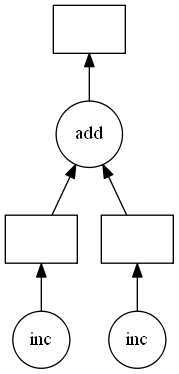

In [202]:
z.visualize()

* deferring computation with Loops

In [158]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [159]:
%%time
# Sequential code

results = []
for x in data:
    y = inc(x)
    results.append(y)
total = sum(results)

Wall time: 8 s


In [160]:
total

44

In [216]:
%%time
# Parallel code

results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

# to get an actual output 
total.compute()

Wall time: 2.12 s


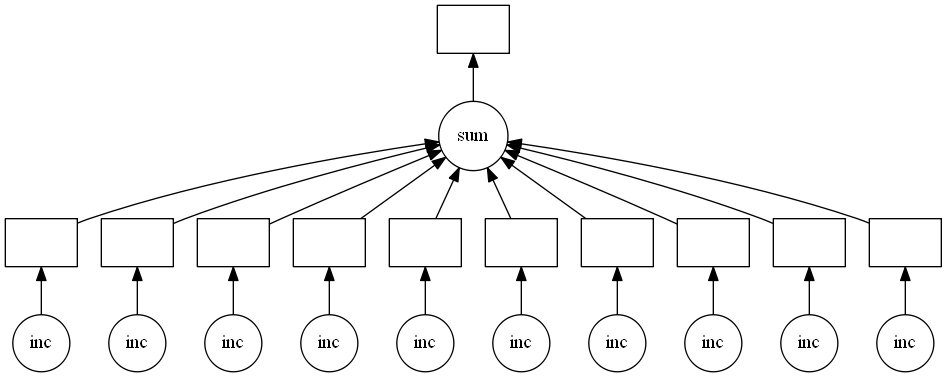

In [217]:
total.visualize()

In [165]:
# let's rewrite code above using decorator functions
@delayed
def inc_delayed(x):
    sleep(1)
    return x + 1

@delayed
def add_delayed(x, y):
    sleep(1)
    return x + y

output = []

for x in data:
    a = inc_delayed(x)
    output.append(a)

total = sum(output)

In [166]:
%%time
total.compute()

Wall time: 1 s


44

* reason for usefullness of `delayed` (instead of just directly working with threads, processes, etc.) is that we can add logic in there, i.e. **flow-control**

* often we want to delay only some functions, running a few of them immediately
    * especially helpful when those functions are fast and help us to determine what other slower functions we should call
* decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`

In the example below we iterate through a list of inputs. If that input is even then we want to call inc. If the input is odd then we want to call double. This is_even decision to call inc or double has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [221]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [222]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
Wall time: 10 s


In [228]:
%%time
results = []
for x in data:
    # is_even is NOT delayed! we need it immediately
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
total.compute()

Wall time: 2.13 s


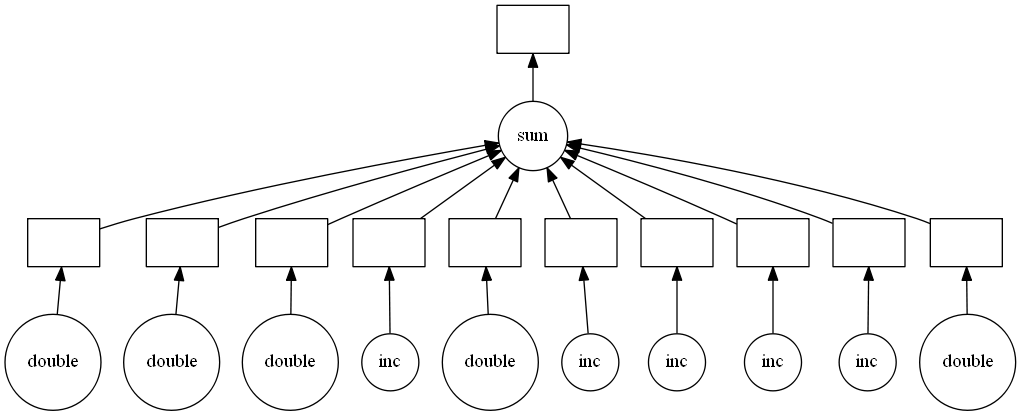

In [230]:
total.visualize()

* automatically assigns tasks to threads or processes
    * you don't have to decompose the tasks yourself

### More "real-world" example
* read several CSV files and perform a groupby operation in parallel
* look at sequential code, then we parallelize it with dask.delayed

In [189]:
import os
import pandas as pd
os.getcwd()

'C:\\Users\\Martin Hronec\\Projects\\phd\\DPP_IES\\XX_Dask'

In [190]:
# columns will be czech, so let's rename them
columns_translation = {'cislo_dot' : 'number',
                    'kod_predm' : 'course_code',
                    'nazev_predm' : 'course_title',
                    'prednasejici' : 'teachers',
                    'cvicici' : 'seminar_leaders',
                    't1': 'c_value',
                    't2': 'c_improve', 
                    'katedra_code' : 'department_code'}

In [237]:
%%time

# relative path to the folder with files
path_to_files = '../07/unzipped_data/'


sums = []
counts = []
# data really start only in later years
for d in os.listdir(path_to_files)[8:]:
        year, semester = d.split('_')[1], d.split('_')[2][:2]
        df_temp = pd.read_csv(path_to_files + d, sep = ';',
                              header = 0, error_bad_lines=False)
        df_temp = df_temp.rename(columns = columns_translation)
        df_temp.dropna(how = 'all', inplace = True, axis = 1)
        df_temp['year'] = int(year)
        df_temp['semester'] = semester
        total = df_temp.groupby('course_code')['q1'].sum()
        count = df_temp.groupby('course_code')['q1'].count()
        
        mean = total / count
        # Save the intermediates
        sums.append(total)
        counts.append(count)

b'Skipping line 1017: expected 21 fields, saw 22\nSkipping line 2087: expected 21 fields, saw 22\nSkipping line 2447: expected 21 fields, saw 22\nSkipping line 2736: expected 21 fields, saw 22\nSkipping line 2828: expected 21 fields, saw 23\nSkipping line 3461: expected 21 fields, saw 24\nSkipping line 3645: expected 21 fields, saw 24\nSkipping line 4490: expected 21 fields, saw 23\n'
b'Skipping line 1816: expected 21 fields, saw 22\nSkipping line 1877: expected 21 fields, saw 22\nSkipping line 3253: expected 21 fields, saw 24\nSkipping line 3270: expected 21 fields, saw 22\nSkipping line 3329: expected 21 fields, saw 22\n'
b'Skipping line 7136: expected 21 fields, saw 23\n'
b'Skipping line 4890: expected 21 fields, saw 22\nSkipping line 8304: expected 21 fields, saw 22\nSkipping line 8358: expected 21 fields, saw 22\n'
b'Skipping line 1145: expected 21 fields, saw 22\nSkipping line 1512: expected 21 fields, saw 22\n'


Wall time: 944 ms


b'Skipping line 279: expected 21 fields, saw 22\nSkipping line 4057: expected 21 fields, saw 22\n'


* we will use dask.delayed to parallelize the code above
* methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls
* calling the `.compute()` method works well when you have a single output. When you have multiple outputs you might want to use the dask.compute function:

In [192]:
from dask import compute

In [258]:
%%time
means = {}

for d in os.listdir(path_to_files)[8:]:
    
        # redundant, just showcasing
        year, semester = delayed(d.split)(('_'))[1], delayed(d.split)(('_'))[2][:2]
        
        df_temp = delayed(pd.read_csv)(path_to_files + d, sep = ';',
                              header = 0, error_bad_lines=False)
        
        df_temp = df_temp.rename(columns = columns_translation)
        df_temp = df_temp.dropna(how = 'all', axis = 1)
        
        total = df_temp.groupby('course_code')['q1'].sum()
        count = df_temp.groupby('course_code')['q1'].count()
        
        mean = total / count
        
        means[d] = mean.values
        
# Compute the intermediates
compute(means)

Wall time: 526 ms


In [259]:
compute(means);

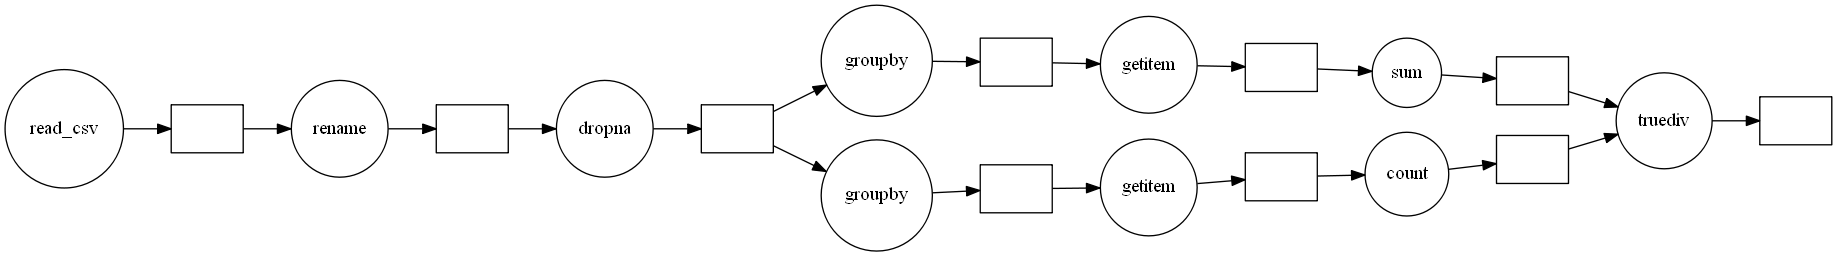

In [260]:
mean.visualize(rankdir='LR')

### Process vs. Thread
* both **processes** and **threads** are independent sequences of execution
* **process** is an instance of program 
* processes spawn **threads** (sub-processes) to handle subtasks
    * threads are entities within a process that can be scheduled for execution
* threads (of the same process) run in a shared memory space
* dask scheduler can assign work to multiple threads or processes if available

## Working with Dask Arrays

* dask arrays share many attributes and methods with the numpy array
    * Attributes: shape, ndim, nbytes, dtype, size, etc.
    * Aggregations: max, min, mean, std, var, sum, prod, etc. 
    * Array transformations: reshape, repeat, stack, flatten, transpose, T, etc. 
    * Mathematical operations: round, real, imag, conj, dot, etc.

In [210]:
import dask.array as da
import numpy as np

In [211]:
a = np.random.rand(100000)

# constructs a dask array from np.array
a_dask = da.from_array(a,chunks = len(a) // 4)

In [212]:
%%time
### Aggregating with np Arrays

n_chunks = 4
chunk_size = len(a) // n_chunks

# accumulate sum explicitly  
result = 0

# within the loop, slice each chunk explicitly, by finding its offset, i.e. actual index where each chunk begins
# each loop is independent, could be executed in parallel
for k in range(n_chunks):
    offset = k * chunk_size # track offset explicitly
    a_chunk = a[offset:offset + chunk_size] # slice chunk explicitly
    result += a_chunk.sum()
    
result

Wall time: 2 ms


In [213]:
%%time
### Aggregating with Dask Arrays

# constructs a dask array from np.array
a_dask = da.from_array(a,chunks = len(a) // n_chunks)
result = a_dask.sum()

result.compute()

Wall time: 81.8 ms


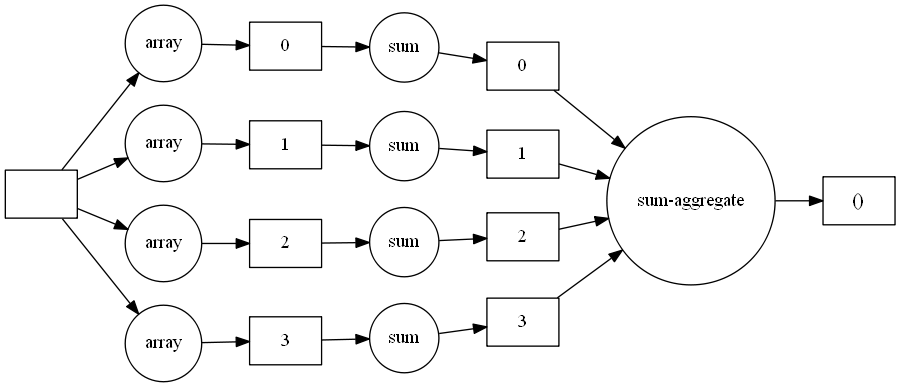

In [256]:
# create graph
result.visualize(rankdir='LR')

### Dask diagnostics dashboard
* more in the official [manual](http://distributed.dask.org/en/latest/web.html)

In [185]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:50402 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


In [186]:
client = Client()
client

C:\Anaconda3\lib\site-packages\distributed\bokeh\core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:50426 Dashboard: http://127.0.0.1:50429/status,Cluster Workers: 4 Cores: 8 Memory: 17.02 GB


# Using Dask DataFrames

* Dask DataFrame is a delayed version of Pandas DataFrame
    * as Dask array is a delyaed version of Numpy array
* substantial overlap of pandas and dask functionality
* capabilities:
    * manipulating large datasets (even when those datasets don’t fit in memory)
    * accelerating long computations by using many cores
    * distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations


* we can also use so called *glob* pattern: `dd.read_csv('*.csv')`

In [238]:
import dask.dataframe as dd

In [239]:
# does not read file immediately (lazy evaluation)
?dd.read_csv;

Object `dd.read_csv;` not found.


In [240]:
df = dd.read_csv(path_to_files + 'data_2017_zs.csv', 
            sep = ';', header = 0, error_bad_lines=False)

b'Skipping line 279: expected 21 fields, saw 22\n'


In [152]:
df

,cislo_dot,kod_predm,nazev_predm,prednasejici,cvicici,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,t1,t2,katedra_code
npartitions=1,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [164]:
df.dtypes

cislo_dot         int64
kod_predm        object
nazev_predm      object
prednasejici     object
cvicici          object
q1              float64
q2              float64
q3              float64
q4              float64
q5              float64
q6              float64
q7              float64
q8              float64
q9              float64
q10             float64
q11             float64
q12             float64
q13             float64
t1               object
t2               object
katedra_code     object
dtype: object

In [165]:
df.head(3)

,cislo_dot,kod_predm,nazev_predm,prednasejici,cvicici,q1,q2,q3,q4,q5,...,q7,q8,q9,q10,q11,q12,q13,t1,t2,katedra_code
0,1,JEB003,Ekonomie I,"Fanta,N.,Kracík,J.,Švarcová,N.","Fanta,N.,Kracík,J.,Švarcová,N.",3.0,5.0,4.0,5.0,4.0,...,4.0,3.0,1.0,4.0,1.0,NaN,2.0,NaN,NaN,ies
1,2,JLB003,Angličtina pro ekonomy I,NaN,"Poslušná,L.",5.0,3.0,NaN,NaN,NaN,...,5.0,5.0,1.0,5.0,5.0,5.0,5.0,NaN,NaN,cjp
2,3,NMMA701,Matematika 1,"Spurný,J.","Rondoš,J.",3.0,5.0,3.0,2.0,1.0,...,4.0,5.0,1.0,3.0,2.0,2.0,1.0,NaN,NaN,ies


In [166]:
#using standard Pandas operations
df2 = df[df.q1 > 4]
df3 = df2.groupby('kod_predm').q1.mean()

In [167]:
df2

,cislo_dot,kod_predm,nazev_predm,prednasejici,cvicici,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,t1,t2,katedra_code
npartitions=1,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [168]:
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: q1, dtype: float64
Dask Name: truediv, 11 tasks

In [169]:
# call compute() when we want the result as a Pandas dataframe
df3.compute()
df2.compute();

* we can watch the status page during computation (link is above)
* we cam persist data in memory (if we have available RAM)

In [245]:
df = dd.read_csv(path_to_files + '*.csv',
                sep = ';', header = 0, error_bad_lines=False)

In [261]:
df.compute();

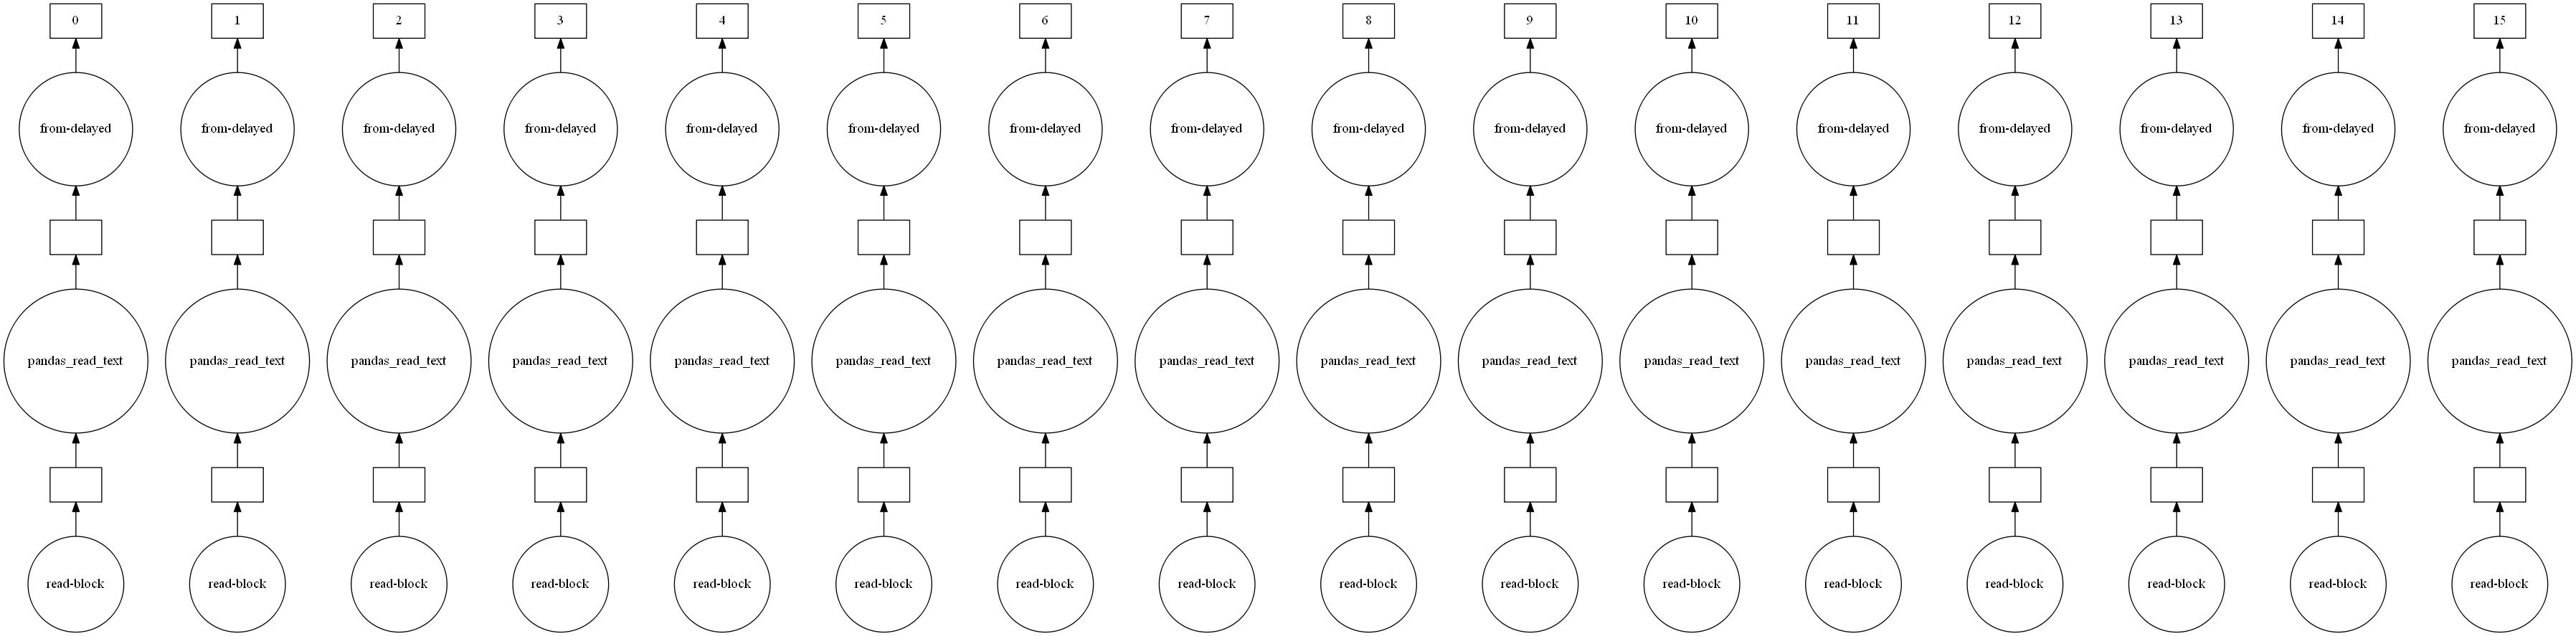

In [262]:
df.visualize()

### Dask delayed best practices
* [official docs](https://github.com/dask/dask/blob/master/docs/source/delayed-best-practices.rst)

